# PIC16B Small Business Predictor

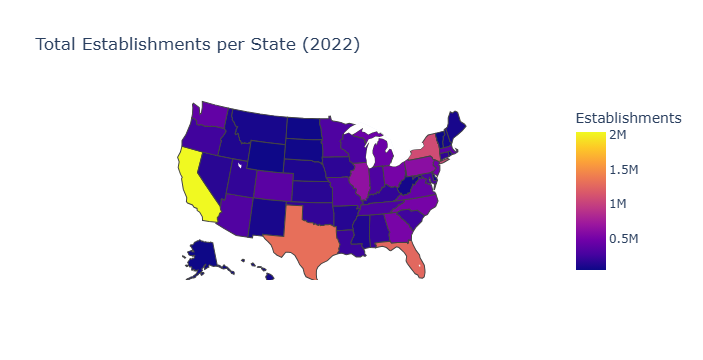

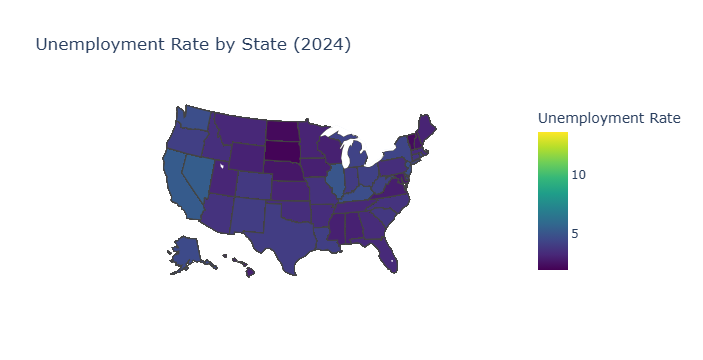

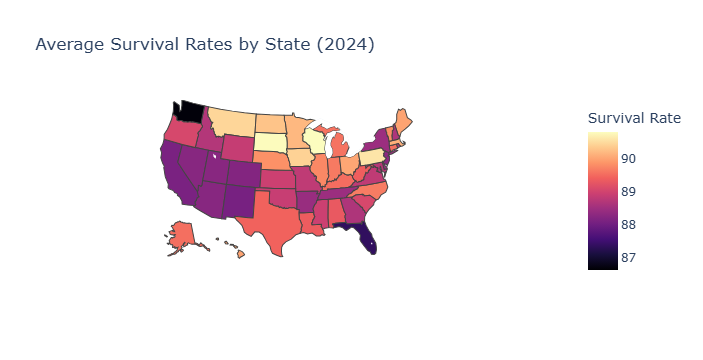

## Project Overview: Predicting Small Business Survival

Welcome to our project, where we walk through our process of creating a machine learning model. This model generates predictions regarding the survival rate of a small business, taking into account its location, industry, and prevailing economic conditions, such as the unemployment rate.

Our project encompassed three key phases:

* **Robust Data Collection:** We established a comprehensive data collection infrastructure to gather the necessary economic and business survival data.
* **Hyperparameter Tuning:** We meticulously tuned the machine learning model's parameters to optimize its predictive performance.
* **Flask Application Development:** We packaged the trained model into a Flask application, enabling user interactivity.

**Purpose and Applications:**

We created this project to assist in the business development process for entrepreneurs -- an industrious person may want to start their passion project in transportation, but maybe right now is not the best time for maximum survival, perhaps when unemployment is a bit lower. Or maybe the location isn't the best, and other regions would be better fit for their startup. 

This tool would also be beneficial to those in analyst roles, who can evaluate the viability of new businesses before having to make a decision on investing or contributing to the new company's mission. 

The repository of all our files can be found here: [(https://github.com/SebastianSeljak/PIC16B_Econ)]

## Part One: Data Collection and Cleaning

To begin with, we needed a source of robust and detailed data for predictor variables to train our model off of. The Bureau of Labor Statistics stores valuable time series data through their Public Data API, and we would use their information to base our project around. 

After combing through the API, we determined the best template of time series to be looking for. BLS had txt files of business survival information based around the state that the business was in, and another format that was centered on the industry the business serves.

The contents of this section can be seen more thoroughly in *dataset.py* and *models.py*'s preprocessing function

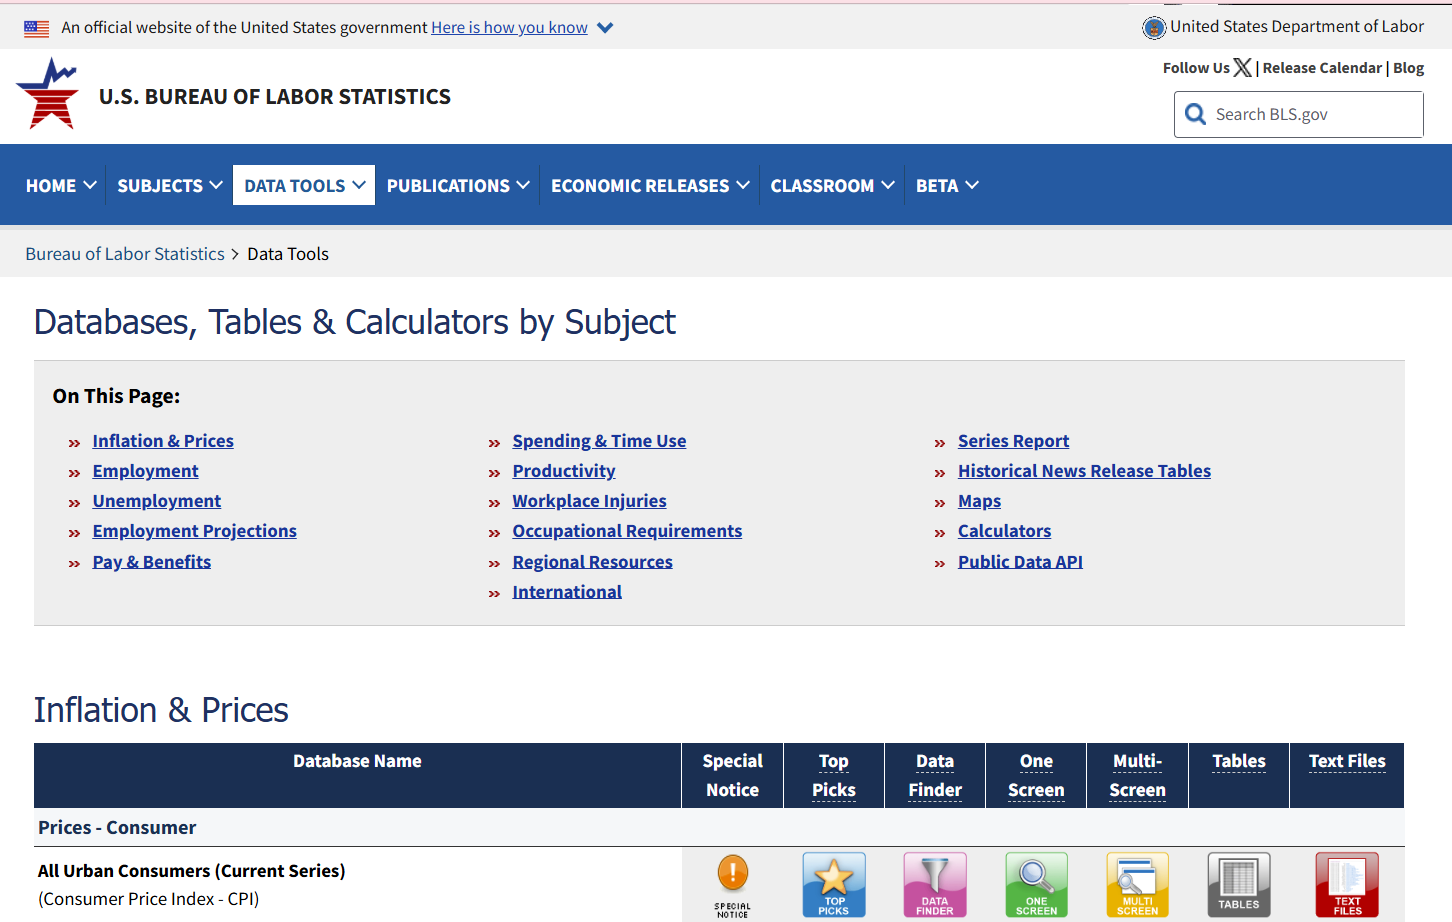

Our data collection process involved a few stages, designed to gather comprehensive economic and business survival data.

**1. Unemployment Data Acquisition:**

* We began by focusing on unemployment data, essential for understanding the economic context.
* This data was collected on a **per-state basis**.
* To efficiently manage this, we created Python dictionaries, mapping each state's name to its corresponding numerical index. This allowed for programmatic access to specific state data.
* We then used these dictionaries to execute API calls efficiently, retrieving the unemployment series data for each state, which was then saved to a folder in csv files.
* We also explored additional economic variables, including **percent wage change**, **hours spent preparing food**, **hours spent watching tv**, and **food expenditure**. These were obtained through similar API calls.
* However, these additional variables suffered from incomplete data ranges. We experimented with data interpolation techniques (linear and cubic) to fill in the gaps, but ultimately, these variables were excluded from the final model to prevent unnecessary complexity and potential inaccuracies.

**2. Establishment Counts:**

* We gathered information on the total number of **establishments (businesses)** in each state, categorized by industry.
* This data, while not directly used as a model input, provided valuable supplementary information for context.

**3. Survival Rate Data:**

* The core of our analysis focused on business survival rates.
* This data required a more complex collection method.
* We used web scraping techniques to extract data from text files. These files were structured to provide survival percentages for each industry within each state, and for each state within each industry.
* These text files contained yearly survival percentages, starting from 1986. Under each year, the survival rates of business 'born' in all previous years was listed. 
* Because each year had its own percentage, we averaged the survival percentages for each year to get a single, representative survival rate.

**4. Data Organization and Scope:**

* In total, we compiled **50 state datasets** and **21 industry datasets**.
* Each dataset contained survival data spanning from 1986 to the present, though we truncated it to only include a 30 year interval.
* We used SQL to merge all of these files into a single database

**5. Data Processing and Visualization:**

* After gathering the raw data, we undertook a thorough data cleaning and preprocessing stage to address inconsistencies and errors.
* Finally, we created visualizations to aid in understanding the data. For example, we produced line graph showing unemployment rates over time for a specific state.

In [ ]:
industry_survival_rates_filtered = industry_survival_rates[industry_survival_rates["Year Established"] != industry_survival_rates["Year"]]
industry_survival_rates_filtered.loc[:, "Year"] = industry_survival_rates_filtered["Year"].astype('int')
industry_survival_rates_filtered.loc[:, "Survival Rates of Previous Year's Survivors"] = industry_survival_rates_filtered["Survival Rates of Previous Year's Survivors"].astype('float')
industry_survival_rates_filtered.loc[:, 'Surviving Establishments'] = industry_survival_rates_filtered['Surviving Establishments'].str.replace(',', '').astype(int)
industry_survival_rates_grouped = industry_survival_rates_filtered.groupby(["Year", "Industry"]).apply(lambda x: np.average(x['Survival Rates of Previous Year\'s Survivors'], weights=x['Surviving Establishments']))

print(industry_survival_rates_filtered.head())

  Year Established  Year Surviving Establishments  \
1             1994  1995                     5537   
2             1994  1996                     4826   
3             1994  1997                     4406   
4             1994  1998                     4005   
5             1994  1999                     3729   

  Total Employment of Survivors Survival Rates Since Birth  \
1                        51,066                       82.1   
2                        48,263                       71.6   
3                        47,634                       65.4   
4                        45,444                       59.4   
5                        39,377                       55.3   

  Survival Rates of Previous Year's Survivors Average Employment of Survivors  \
1                                        82.1                             9.2   
2                                        87.2                            10.0   
3                                        91.3                            10.8   
4                                        90.9                            11.3   
5                                        93.1                            10.6   

                                     Industry  
1  Agriculture, Forestry, Fishing and Hunting  
2  Agriculture, Forestry, Fishing and Hunting  
3  Agriculture, Forestry, Fishing and Hunting  
4  Agriculture, Forestry, Fishing and Hunting  
5  Agriculture, Forestry, Fishing and Hunting  

**Data Cleaning and Preprocessing:**

Our data cleaning process followed a structured approach to ensure consistency and usability for our model.

* **Database Integration:** After loading our data into a SQL file, we accessed each dataframe individually and created tables that focused on unemployment, state business survival, industry-specific survival rates, and the total number of establishments per year.
* **Data Standardization:** We then standardized the data within these tables. This involved:
    * Ensuring uniform data types across all columns (e.g., all numerical values were consistently formatted).
    * Removing extraneous characters, such as commas, from numerical data.
* **Aggregation and Averaging:** To produce a single, representative value for each year, we grouped these tables by year and their state or industry, to give us a weighted average of performance in that one year. The process is depicted in the above snippet, and returns an output in that format. 

**Addressing the Independence Assumption:**

A key challenge in our analysis stemmed from the structure of the Bureau of Labor Statistics (BLS) data.

* **Data Separation:** The BLS data was given in two formats, one grouped by states, and another grouped by industry. This meant that we had separate survival rate data for each state and each industry, but not for specific state-industry combinations.
* **Independence Assumption:** Ideally, we would have used Bayes' theorem to calculate the exact probability of a business's survival given both its state and industry. However, data limitations forced us to make an independence assumption. We assumed that state and industry survival rates were independent of each other.
* **Establishment Data Integration:** To overcome this usse, we incorporated the raw establishment numbers from the establishment table into this combined dataset, by multiplying the probabilities of survival per state and industry, then dividing by the total probability, deduced from the establishment count
* **Model Input Preparation:**  With all of these values collected, we constructed a combined dataset, where the industry and state data was joined on the year, and the pooled survival rate was used along with the raw establishments numbers from the other table, which will be used to train our model.

## Training the Model

**Model Architecture and Training:**

Our machine learning approach centered on a Multi-Layer Perceptron (MLP) design, implemented using PyTorch.

* **Custom Datasets:**
    * We began by creating custom `torch.Dataset` classes to handle our training and testing data.
    * Initially, the input features included a single unemployment statistic, along with one-hot encoded state and industry categorical variables. The dimensions of the one hot encoded vectors were 51 for states and 21 for industries.
    * For numerical stability, we applied min-max scaling from sklearn, to rescale the unemployment data.
    * Later, we experimented with custom embeddings to mitigate the potential dominance of zero values from the one-hot encoding, which could have drowned out the unemployment statistic, as we found in our initial model implementations.
* **Base Model: `SurvivalRateModel`:**
    * We developed a base model, `SurvivalRateModel`, which encapsulated the core functionality of our network, including `train`, `predict`, and `evaluate` methods.
* **Model Variations and Regularization:**
    * Building upon the base model, we explored several variations to enhance performance and address overfitting. These included:
        * `SurvivalRateModel_AggressiveReg`:
            * This model incorporated batch normalization, dropout, elastic net regularization (L1 and L2), which essentially sums up all the model parameters and adds a multiple of them to the loss, and finally gaussian noise injection to improve generalization.
        * `SurvivalRateModel_DeepLearning`:
            * This model featured a deeper architecture with additional hidden layers and leaky ReLU activation functions. It was an attempt at reaching overfitting of our data
        * `SurvivalRateModel_Combined`:
            * This model combined the features of the previous two, incorporating batch normalization, dropout, elastic net regularization, noise injection, and a breadth loss term to encourage diverse predictions, which we found in our (later) architecture phase to be particularly helpful
            * Breadth loss was added to encourage the model to create a wide range of predictions.
        * `SurvivalRateModel_Embeddings`:
            * This Model uses embedding layers to represent the categorical data, rather than one hot encoded vectors.
            * This drastically reduces the input size to the model.
* **Architecture Exploration:**
    * We undertook an extensive architecture exploration phase, experimenting with various combinations of PyTorch layers, including layer normalization, ReLU, pooling, sigmoid, and tanh activation functions.
    * This led to a second phase of exploration, where we implemented more drastic architectural changes, including:
        * `OneLayerModel`: A model with a single hidden layer and no sigmoid activation.
        * `DeepNarrowModel`: A deep model with small hidden layers and no sigmoid activation.
        * `ModifiedSigmoidModel`: A model with a modified sigmoid output range (65-100).
        * `BreadthLossModel`: A model that incorporates a breadth loss term during training.
        * `LRSchedulerModel`: A model that uses a learning rate scheduler.
        * Models that use the optimizers, SGD, RMSProp, and Adagrad.
    
* **Third Round Architecture Tuning:**
    * We initialized our training and testing datasets using the `EconDataset` class.
    * We then defined several models, including:
        * `Baseline SurvivalRateModel`: Our initial baseline model.
        * `Embedded SurvivalRateModel`: A model using embedding layers for categorical features, replacing one-hot encoding.
        * `BreadthLossModel`: Several variations of this model with varying breadth loss lambda hyper parameters.
        * `BreadthLossModelEmbed`: A Breadth Loss Model that also uses embeddings.
    * We then trained and evaluated each model, logging the results. The breadth loss models were trained with varying lambda values, to see the effect of this hyper parameter.

* **Training and Evaluation Loop:**
    * We used the MSE loss function as our core indicator of model success. Our model tended to reach around ~10 MSE, meaning sqrt(10) percentage points off on each prediction. Not too bad.
    * To test model architectures, we used the r2 score between predicted and actual values in the validation set
    * We used early stopping, with a patience of 50 epochs, to prevent overfitting.
    * We experimented with various optimizers and learning rate schedules.

Below is the Embedded model architecture:

In [ ]:
class SurvivalRateModel_Embeddings(SurvivalRateModel):
    def __init__(self, num_states, num_industries, embedding_dim=8, hidden_size1=64, hidden_size2=32):
        # Calculate the input size for the main network
        combined_input_size = 1 + embedding_dim + embedding_dim  # unemployment + state_emb + industry_emb
        super().__init__(combined_input_size, hidden_size1, hidden_size2)
        
        # Create embeddings for categorical variables
        self.state_embedding = nn.Embedding(num_states, embedding_dim)
        self.industry_embedding = nn.Embedding(num_industries, embedding_dim)
    
    def forward(self, x):
        # Split the input
        unemployment = x[:, 0:1]  # First column
        state_oh = x[:, 1:52]     # Next 51 columns
        industry_oh = x[:, 52:]   # Remaining columns
        
        # Convert one-hot back to indices for embedding lookup
        state_idx = torch.argmax(state_oh, dim=1)
        industry_idx = torch.argmax(industry_oh, dim=1)
        
        # Get embeddings
        state_emb = self.state_embedding(state_idx)
        industry_emb = self.industry_embedding(industry_idx)
        
        # Combine features
        combined = torch.cat([unemployment, state_emb, industry_emb], dim=1)
        
        # Pass through layers
        return 100 * self.layers(combined)

## Hyperparameter Tuning with Weights & Biases (WandB)

To explore the hyperparameter space and optimize our model's performance, we utilized Weights & Biases (WandB), a powerful experiment tracking and visualization platform. We employed a **random search** strategy to efficiently sample diverse hyperparameter combinations.

**Sweep Configuration:**

We defined a configuration that specified the, search method the metric to optimize, and the ranges for each hyperparameter.

* **Optimization Metric:** We aimed to minimize the **best validation loss**, representing the lowest validation loss achieved during training, though also tracked training MSE as a secondary variable.
* **Hyperparameter Ranges:**
    * **Hidden Layer Sizes:** We explored various sizes for the hidden layers of our MLP, including 32, 64, 128, 256, and 512 neurons.
    * **Learning Rate:** A logarithmic uniform distribution to sample learning rates over the range: 1e-6 to 1e-1.
    * **Regularization Strengths (L1 and L2):** Also form a logarithmic uniform distribution
    * **Noise Standard Deviation:** We adjusted the standard deviation of noise injected into the input data, ranging from 0.01 to 0.1. This had little effect on the model
    * **Dropout Rate:** We varied the dropout rate to control regularization, with values ranging from 0.0 to 0.5. Dropout rate had a strong correlation with performance
    * **Breadth Loss Lambda:** Used to tune the breadth loss effect, values from 0.01 to 1.
    * **Batch Size:** We experimented with different batch sizes to optimize training efficiency, including 32, 64, 128, 256, and 512.

**Sweep Execution:**

We initiated the WandB sweep and ran the agent to execute the training function for **300** hyperparameter combinations. This process allowed us to effectively explore the hyperparameter space and identify the optimal configuration for our model, resulting in improved performance and generalization.

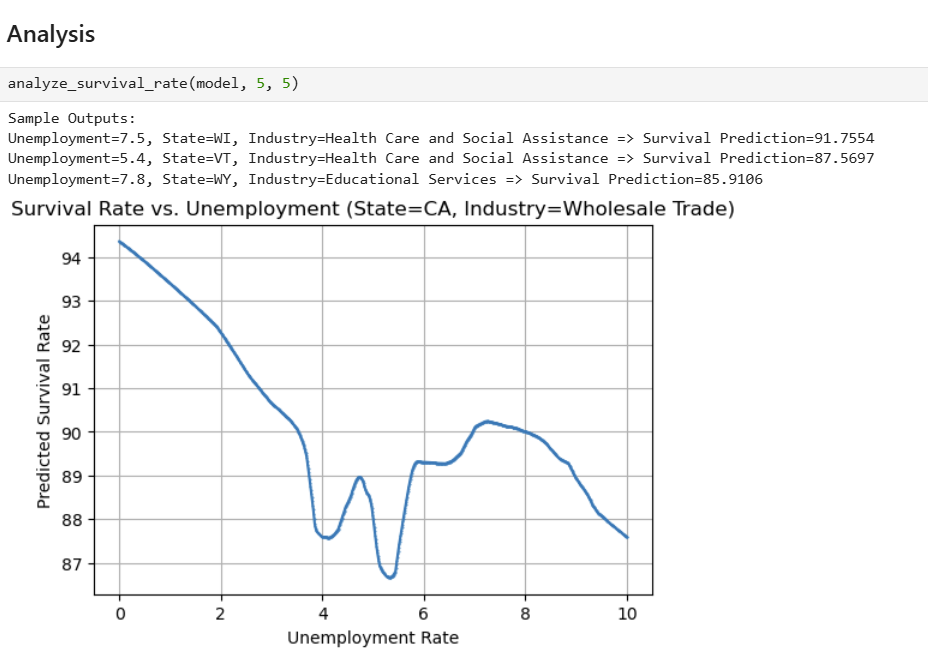

## Flask Application: Interactive Business Survival Rate Prediction

To provide users with a practical and accessible way to interact with our trained machine learning model, we developed a simple Flask web application. It serves as a user-friendly interface for generating business survival rate predictions based on user-defined inputs.

**Functionality:**

* **Industry Selection:** Users can select any industry recognized by the BLS from a drop-down menu.
* **Unemployment Rate Input:** Users can input a floating-point value representing the unemployment rate. This allows for flexible scenario analysis, where users can explore the impact of varying economic conditions on business survival. 
* **Geographical Visualization:** After submission our model generates a map of the United States. This map visually represents the predicted business survival rates across different states
* **Granular Numerical Data:** In addition to the map visualization, the application displays a table containing the predicted survival rates for all 51 states. This table provides users with more granular numerical data, allowing for detailed comparisons and analysis of state-specific predictions.

**Purpose:**

This Flask application aims to bridge the gap between our machine learning model and end-users, enabling them to:

* Explore the potential impact of different economic scenarios on business survival.
* Compare predicted survival rates across various industries and locations.
* Gain valuable insights for business planning, investment decisions, and market analysis.

By combining the predictive power of our machine learning model with the interactive capabilities of a web application, we have created a tool that empowers users to make informed decisions based on data-driven insights.

![Screenshot 2025-03-21 at 9.33.17 PM.png](<attachment:Screenshot 2025-03-21 at 9.33.17 PM.png>)
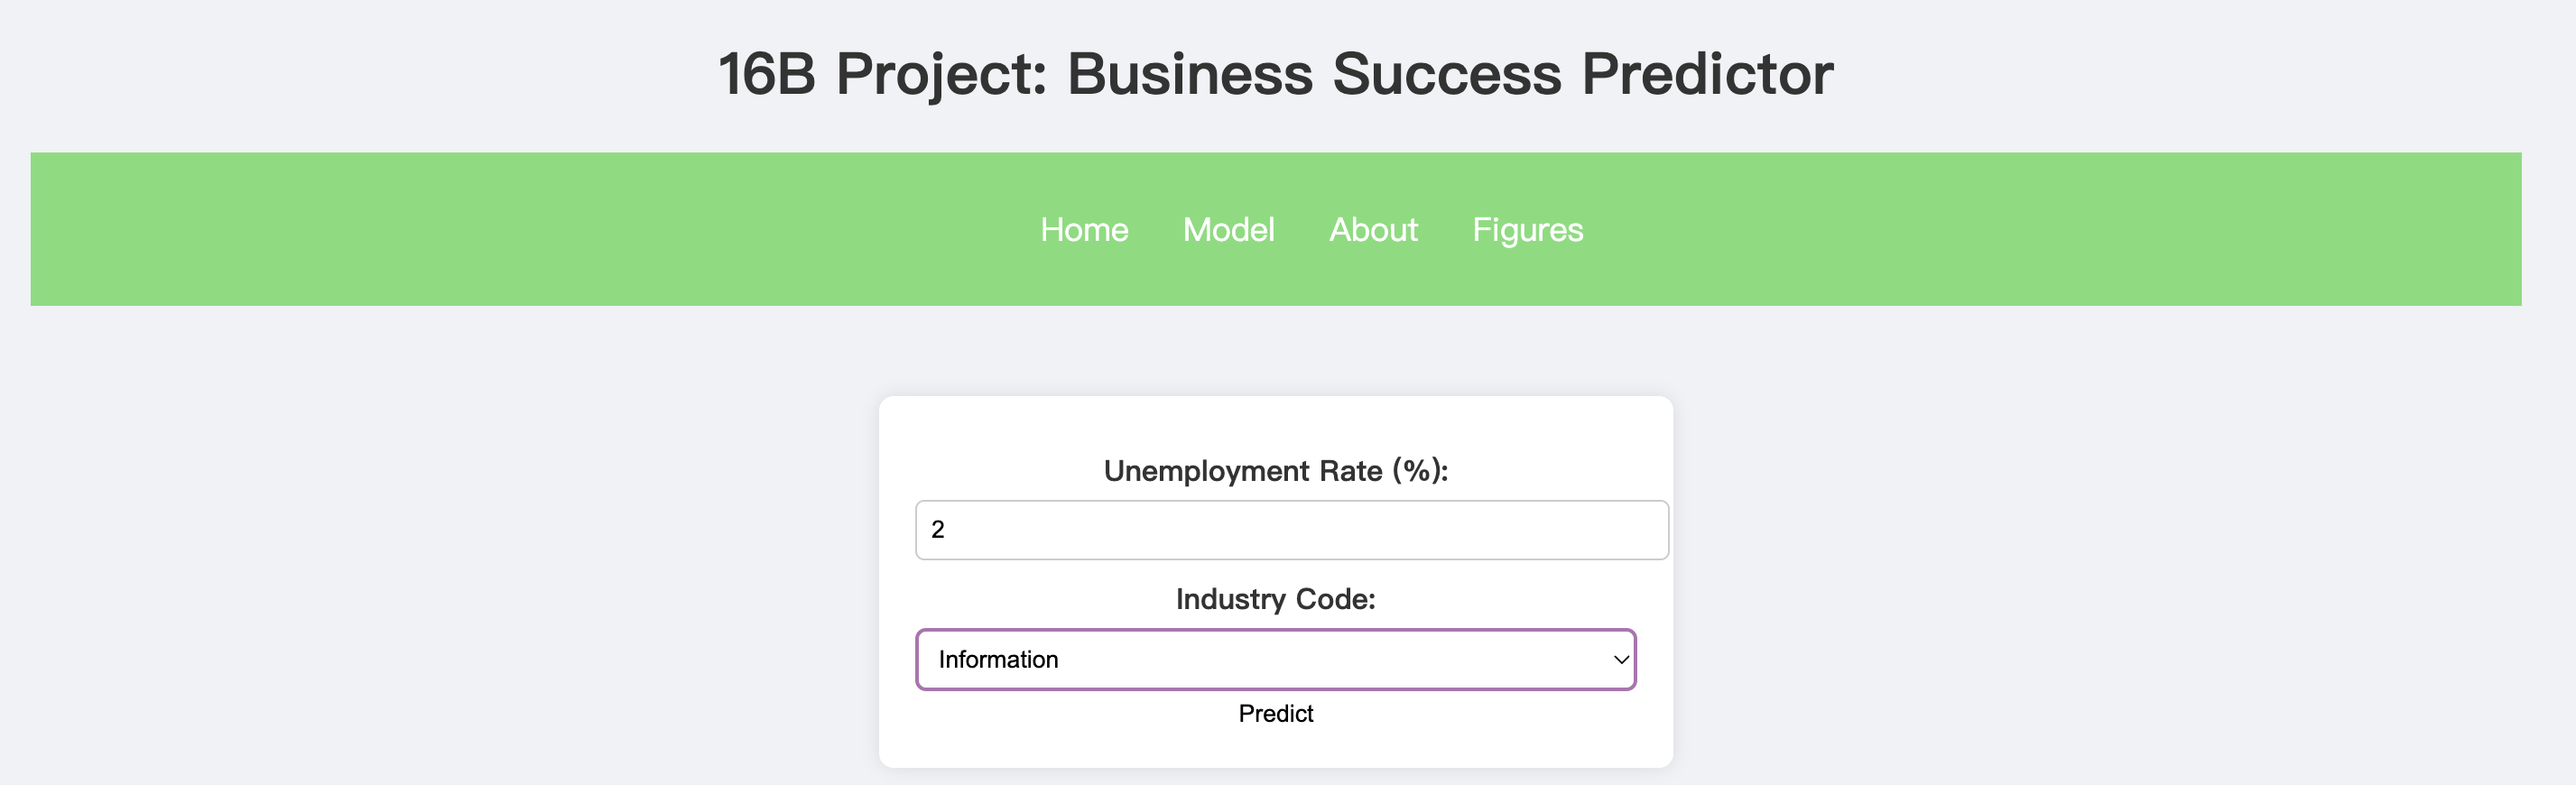

![Screenshot 2025-03-21 at 9.33.23 PM.png](<attachment:Screenshot 2025-03-21 at 9.33.23 PM.png>)
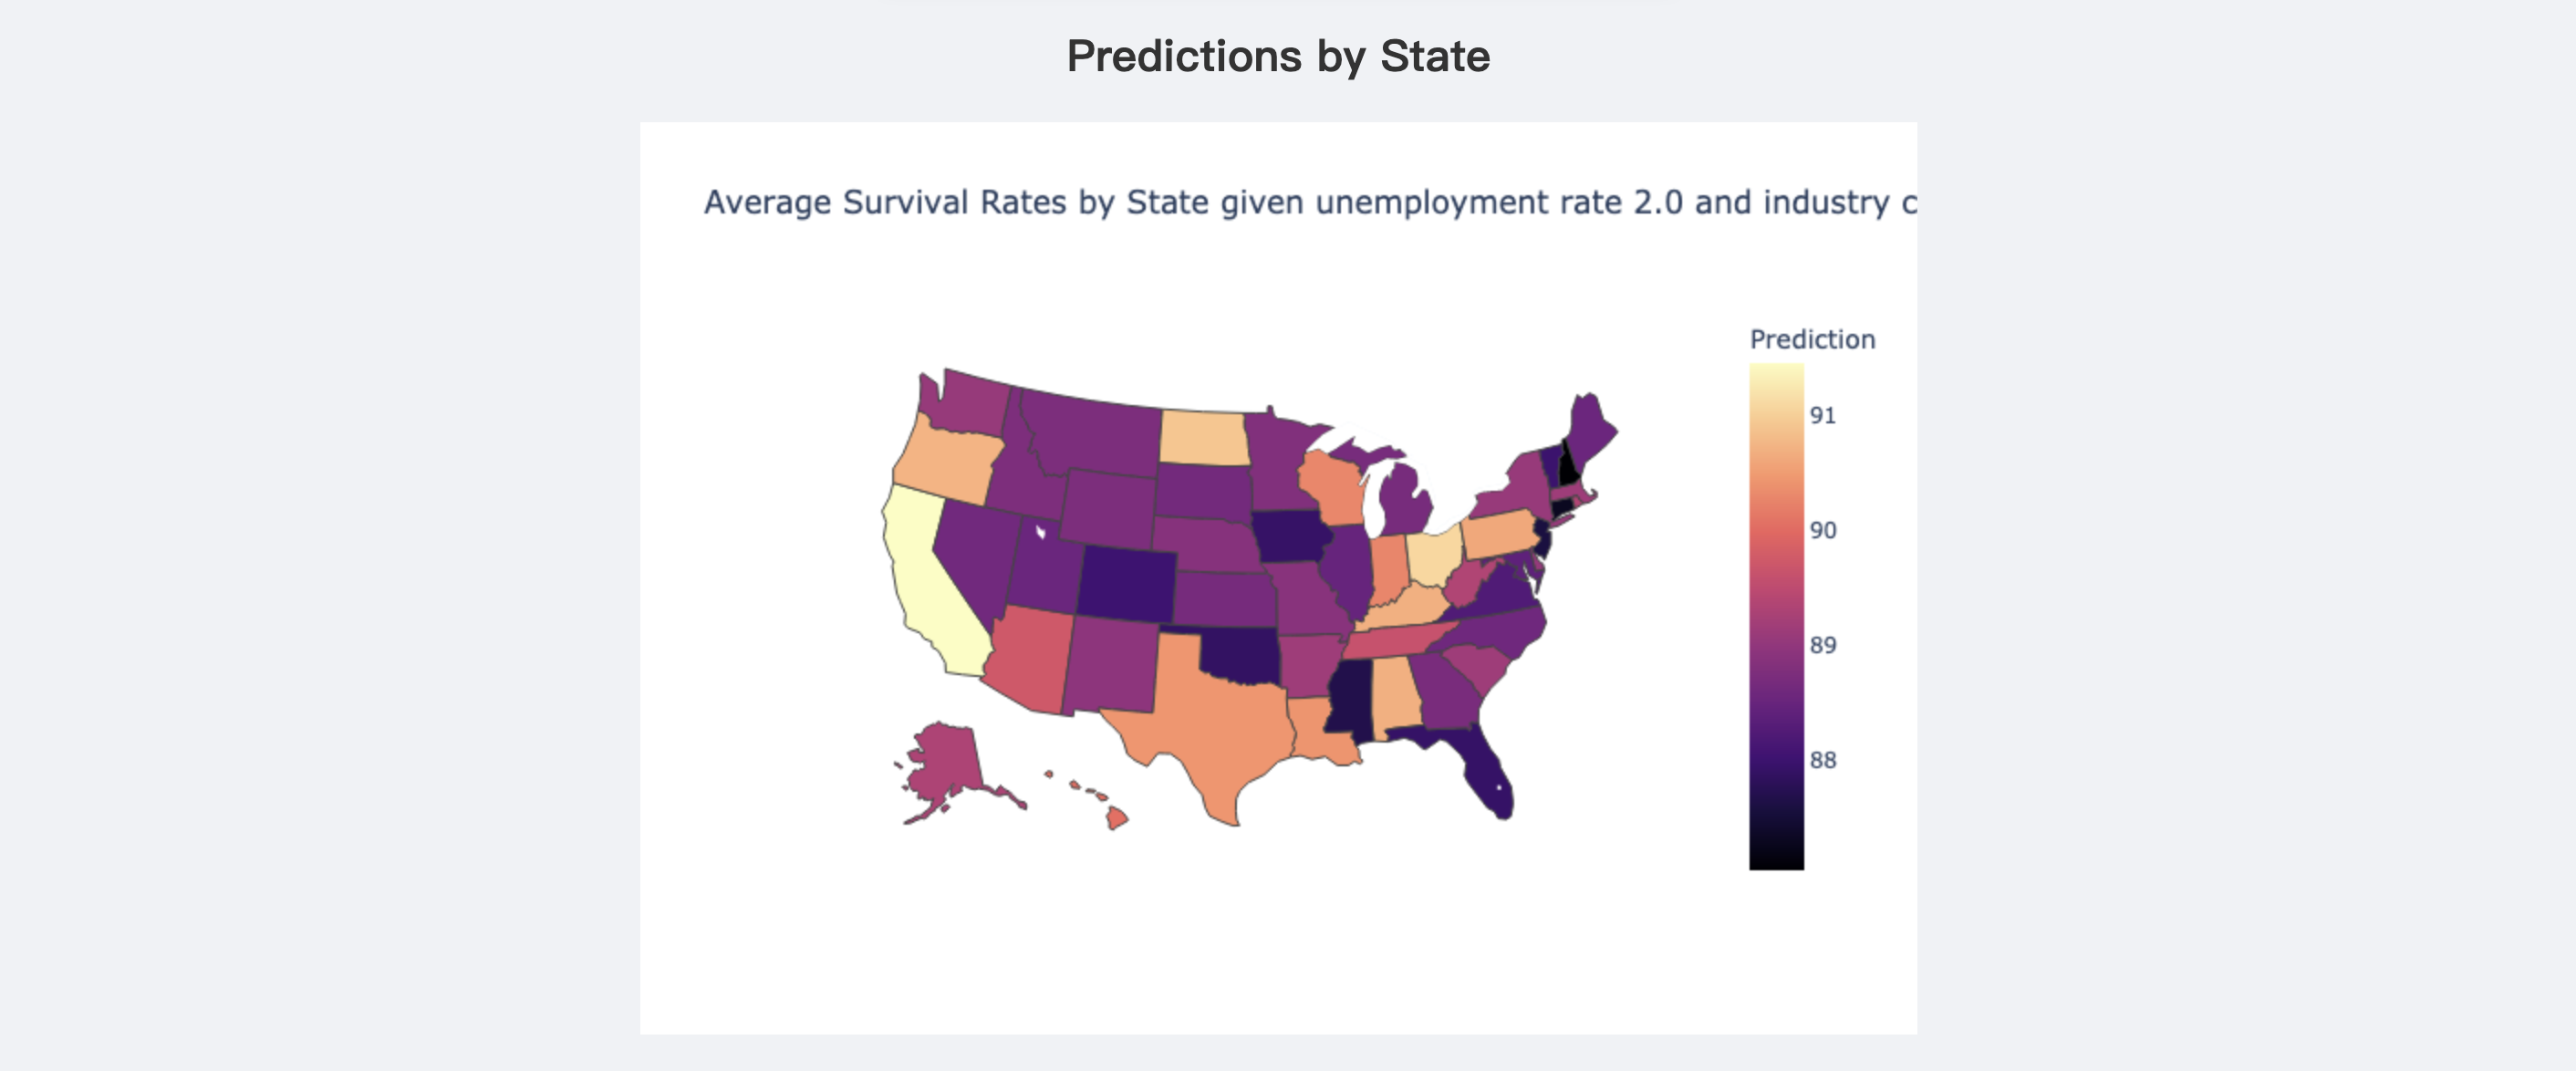

![Screenshot 2025-03-21 at 9.33.32 PM.png](<attachment:Screenshot 2025-03-21 at 9.33.32 PM.png>)
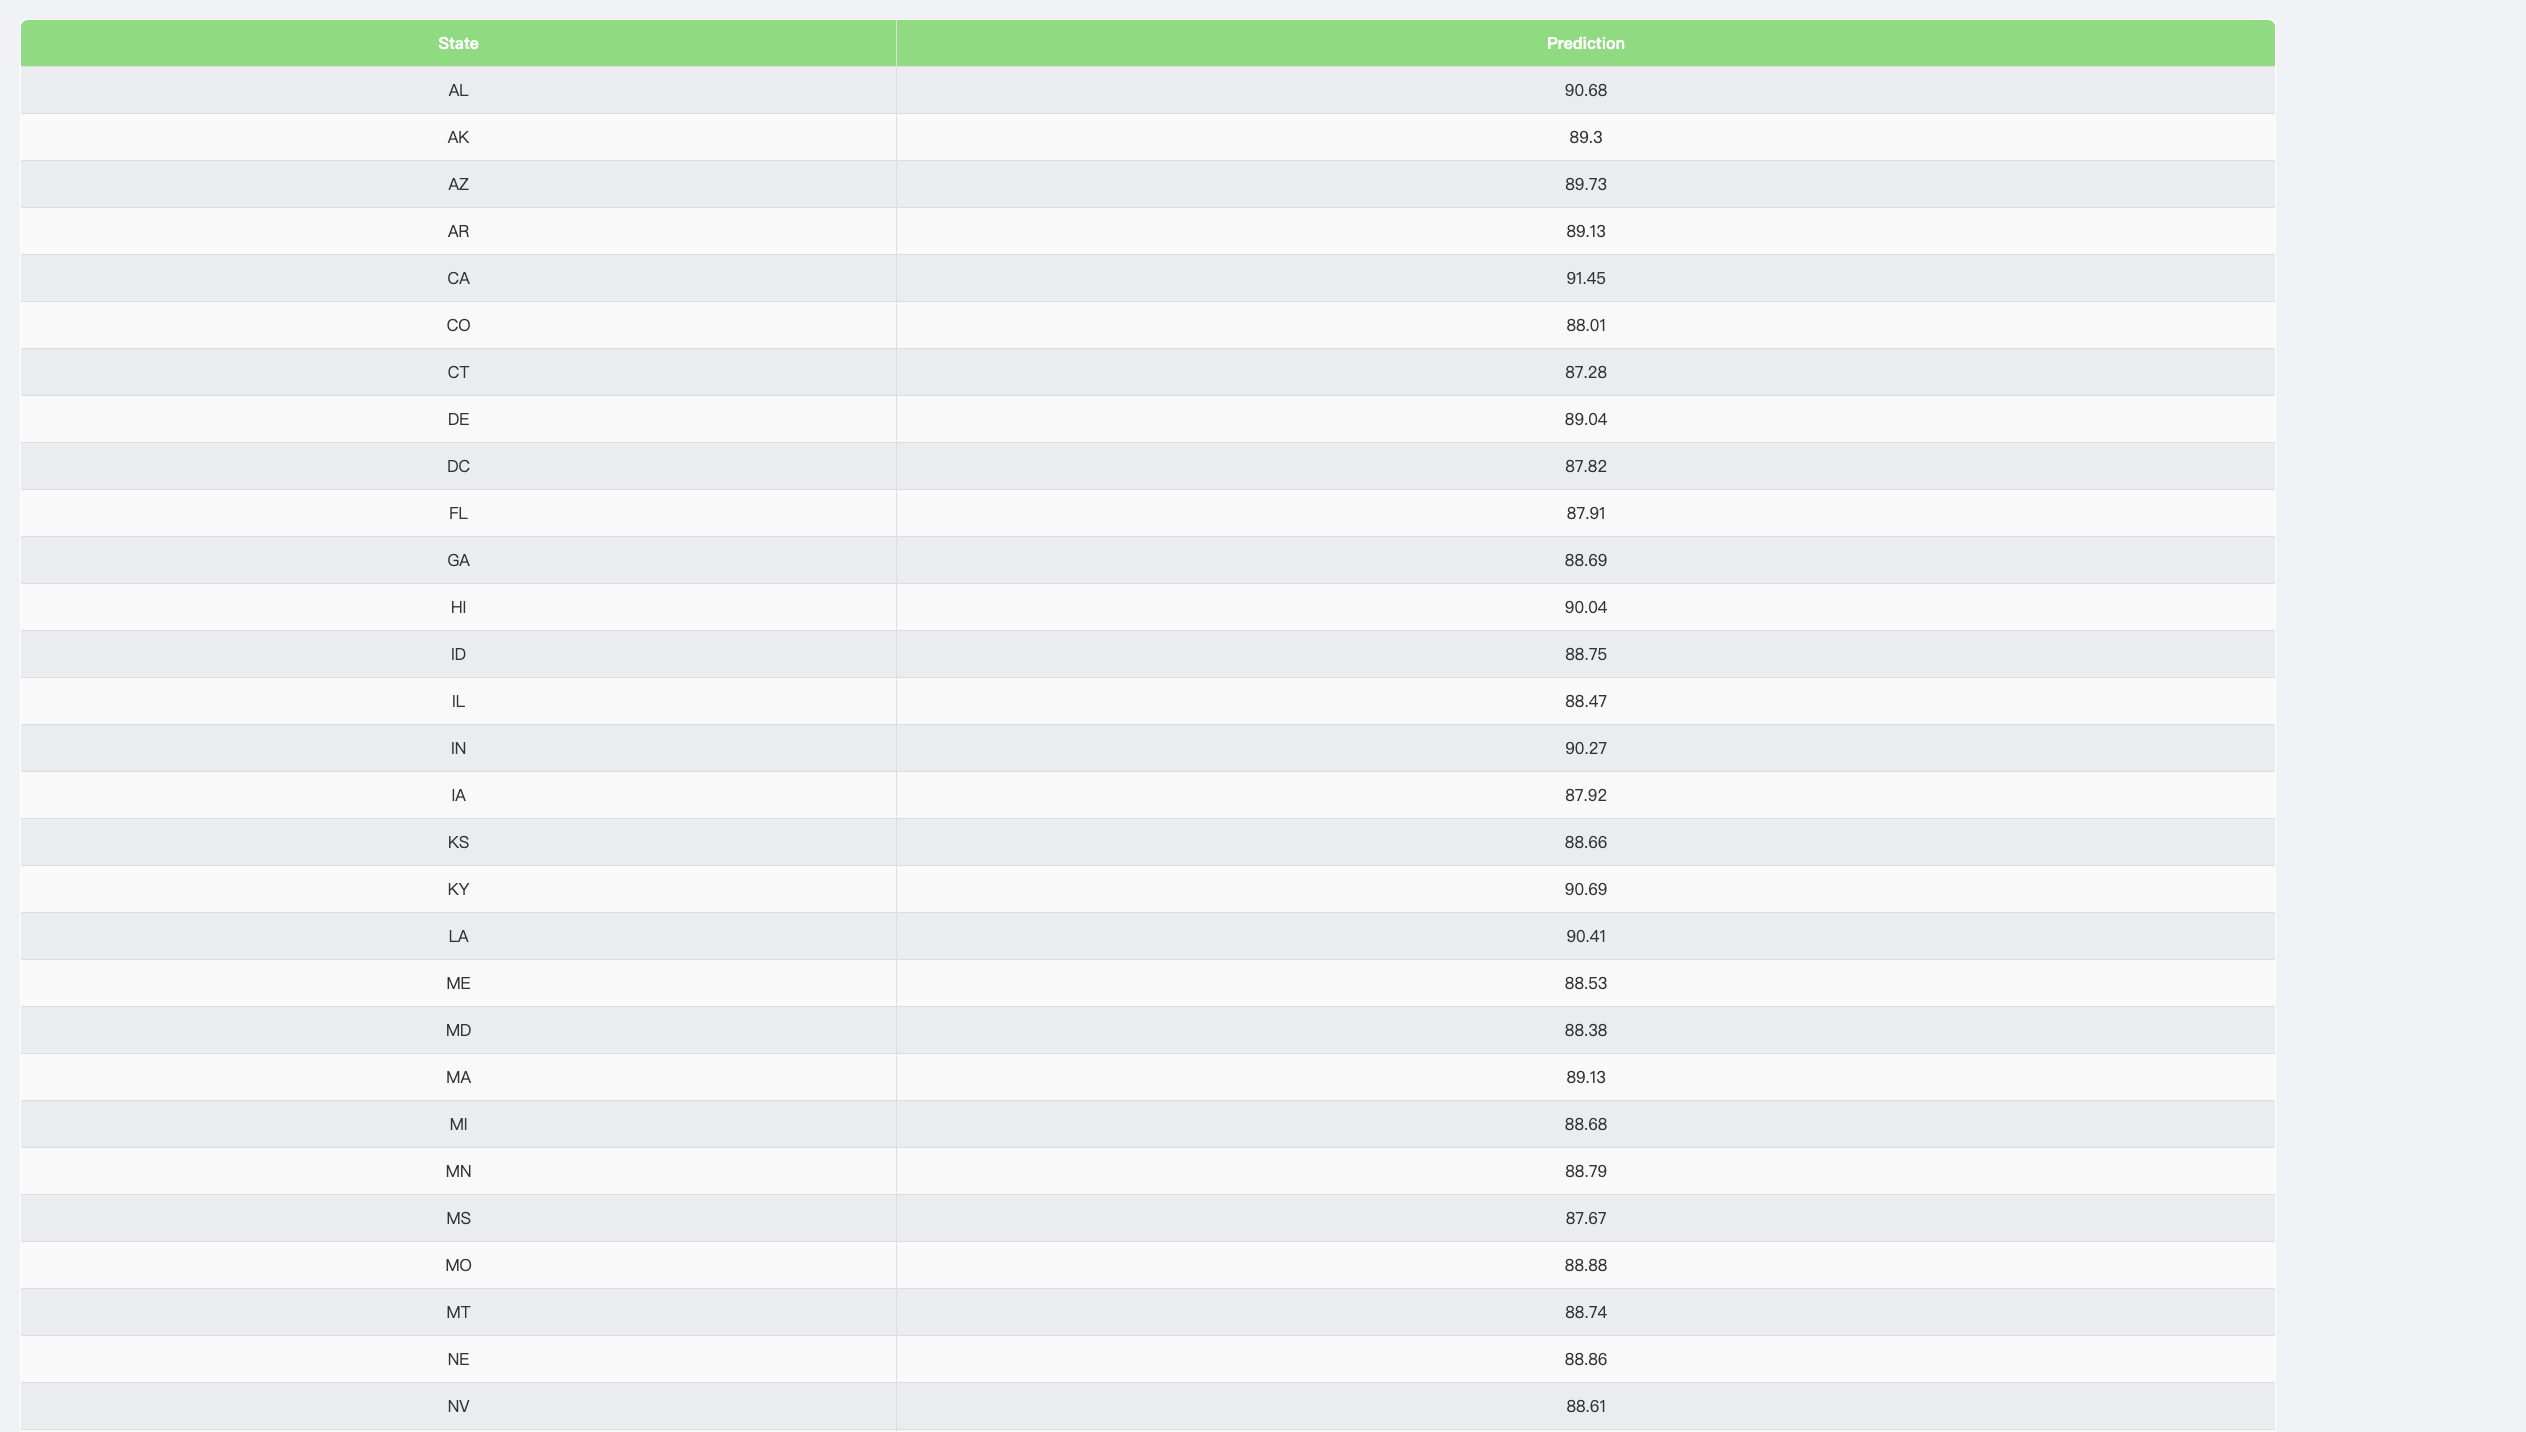